In [1]:
from configPy import Config, DirManager
from src.process_audio.remove_silence import remove_silence
from src.process_audio.convert_audio import convert_audio
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt 
file_dir = Config.get_dir_files()
audios_dir = file_dir["audios"]

# dir de teste
test_dir = file_dir.create_dir("test")


In [2]:
# string dos nomes de cada arquivo
files_names = [
    "sessao-de-9-9-2020-Ata70.webm",
    "sessao-de-25-6-2021-Ata47.webm",
    "sessao-de-20-10-2022-Ata93.webm",
    "sessao-de-2-6-2023-AtaSolene4.webm",
    "sessao-de-20-8-2024-1-ATA63.webm",
    ]

path_files = [audios_dir[f] for f in files_names]

In [5]:
print(convert_audio(input_audio=path_files[0], output_dir=test_dir,show_log=True))

Input #0, matroska,webm, from '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/audios/sessao-de-9-9-2020-Ata70.webm':
  Metadata:
    encoder         : google/video-file
  Duration: 03:10:40.02, start: -0.007000, bitrate: 109 kb/s
  Stream #0:0(eng): Audio: opus, 48000 Hz, stereo, fltp (default)
Stream mapping:
  Stream #0:0 -> #0:0 (opus (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/sessao-de-9-9-2020-Ata70.wav':
  Metadata:
    ISFT            : Lavf60.16.100
  Stream #0:0(eng): Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, mono, s16, 705 kb/s (default)
    Metadata:
      encoder         : Lavc60.31.102 pcm_s16le


/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/sessao-de-9-9-2020-Ata70.wav


[out#0/wav @ 0x555f8a8a60c0] video:0kB audio:985359kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000008%
size=  985359kB time=03:10:40.00 bitrate= 705.6kbits/s speed= 141x    


In [3]:
num_bins = 100
min_db, max_db = -80.0, 0.0  # faixa de dB para histogramas
hist_counts = np.zeros(num_bins, dtype=np.float64)

path = test_dir[".".join([files_names[0].split(".")[0], "wav"])]

eps = 1e-10  # evita log(0)

with sf.SoundFile(path) as f:
    blocksize = 4410  # ~100ms se 44.1kHz
    while True:
        samples = f.read(blocksize, dtype="float32")
        if len(samples) == 0:
            break

        # Se for estéreo, faz média para mono
        if samples.ndim > 1:
            samples = samples.mean(axis=1)

        # Normaliza [-1, 1] (opcional)
        # samples = samples / np.max(np.abs(samples), initial=1.0)

        # Converte amplitude para decibéis
        samples_db = 20 * np.log10(np.maximum(np.abs(samples), eps))

        # Atualiza histograma em dB
        counts, bin_edges = np.histogram(samples_db, bins=num_bins, range=(min_db, max_db))
        hist_counts += counts

# Normaliza histograma
hist_probs = hist_counts / np.sum(hist_counts)

# Calcula thresholds automáticos
sorted_db = np.sort(samples_db)
silence_threshold = np.percentile(sorted_db, 5)   # 5% mais baixo = silêncio
murmur_threshold = np.percentile(sorted_db, 15)   # 15% mais baixo = murmúrios

print("Histograma bruto (dB):", hist_counts)
print("Histograma normalizado (dB):", hist_probs)
print("Threshold de silêncio (dB):", silence_threshold)
print("Threshold de murmúrios (dB):", murmur_threshold)


Histograma bruto (dB): [0.0000000e+00 0.0000000e+00 1.6988930e+06 0.0000000e+00 1.6889410e+06
 0.0000000e+00 1.6788830e+06 0.0000000e+00 1.6641600e+06 1.6521420e+06
 1.6332900e+06 0.0000000e+00 1.6186250e+06 1.6002910e+06 3.1500260e+06
 1.5435270e+06 1.5261810e+06 2.9936090e+06 1.4646340e+06 2.8688410e+06
 2.7891020e+06 2.7038010e+06 3.9120770e+06 2.5118590e+06 3.6343740e+06
 3.4868390e+06 4.4405300e+06 4.2051120e+06 3.9971110e+06 3.8003170e+06
 4.4998470e+06 5.0746110e+06 4.7493360e+06 5.1634210e+06 4.8089810e+06
 5.1148100e+06 4.7515860e+06 5.4863370e+06 5.0528790e+06 5.5766280e+06
 5.5380070e+06 5.1047870e+06 5.4280900e+06 5.6656520e+06 5.5452300e+06
 5.7085200e+06 5.8366010e+06 5.9251460e+06 5.9947250e+06 6.2527470e+06
 6.4560490e+06 6.4429360e+06 6.7651190e+06 7.0353890e+06 7.2371180e+06
 7.4064940e+06 7.6691670e+06 7.8680330e+06 8.1387580e+06 8.4604660e+06
 8.5952220e+06 8.8773430e+06 9.1737250e+06 9.3007560e+06 9.6055260e+06
 9.8210640e+06 1.0005858e+07 1.0164356e+07 1.0344248e+

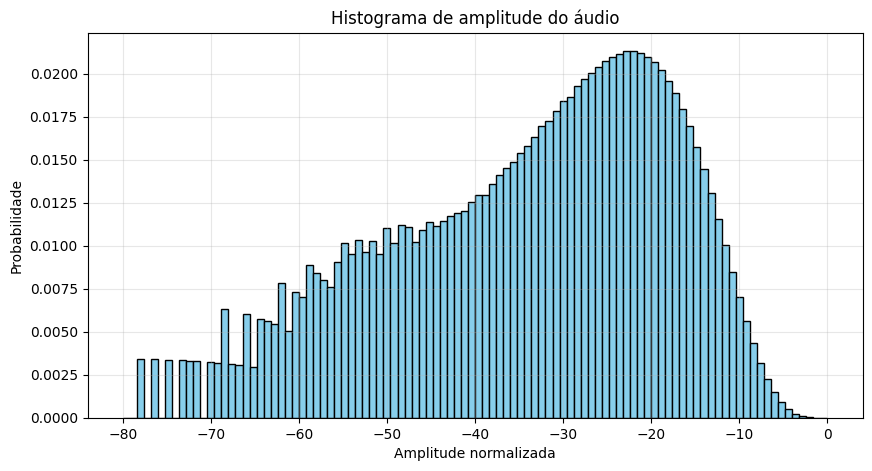

In [4]:
# Plot
plt.figure(figsize=(10,5))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers, hist_probs, width=bin_edges[1]-bin_edges[0], color='skyblue', edgecolor='black')
plt.title("Histograma de amplitude do áudio")
plt.xlabel("Amplitude normalizada")
plt.ylabel("Probabilidade")
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
# Diretórios de teste

test_manual_30_dir = test_dir.create_dir("test_manual_30")
test_manual_40_dir = test_dir.create_dir("test_manual_40")
test_automatic_threshold_dir = test_dir.create_dir("test_automatic_threshold")
test_murmur_threshold_dir = test_dir.create_dir("test_murmur_threshold")

In [6]:
# remover silêncio usando -30 com threshold

remove_silence(
    input_audio=path_files[0],
    output_dir=test_manual_30_dir,
    silence_threshold=-30,
    show_log=True)

Input #0, matroska,webm, from '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/audios/sessao-de-9-9-2020-Ata70.webm':
  Metadata:
    encoder         : google/video-file
  Duration: 03:10:40.02, start: -0.007000, bitrate: 109 kb/s
  Stream #0:0(eng): Audio: opus, 48000 Hz, stereo, fltp (default)
Stream mapping:
  Stream #0:0 -> #0:0 (opus (native) -> opus (libopus))
Press [q] to stop, [?] for help
[libopus @ 0x558c1b3410c0] No bit rate set. Defaulting to 96000 bps.
Output #0, webm, to '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_manual_30/sessao-de-9-9-2020-Ata70.webm':
  Metadata:
    encoder         : Lavf60.16.100
  Stream #0:0(eng): Audio: opus, 48000 Hz, stereo, flt, 96 kb/s (default)
    Metadata:
      encoder         : Lavc60.31.102 libopus
[out#0/webm @ 0x558c1b2fb100] video:0kB audio:111638kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.533337%
size=  115582kB time=03:09:49.64 bitrate=

PosixPath('/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_manual_30/sessao-de-9-9-2020-Ata70.webm')

In [7]:
# remover silêncio usando -40 com threshold

remove_silence(
    input_audio=path_files[0],
    output_dir=test_manual_40_dir,
    silence_threshold=-40,
    show_log=True)

Input #0, matroska,webm, from '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/audios/sessao-de-9-9-2020-Ata70.webm':
  Metadata:
    encoder         : google/video-file
  Duration: 03:10:40.02, start: -0.007000, bitrate: 109 kb/s
  Stream #0:0(eng): Audio: opus, 48000 Hz, stereo, fltp (default)
Stream mapping:
  Stream #0:0 -> #0:0 (opus (native) -> opus (libopus))
Press [q] to stop, [?] for help
[libopus @ 0x55f6490c70c0] No bit rate set. Defaulting to 96000 bps.
Output #0, webm, to '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_manual_40/sessao-de-9-9-2020-Ata70.webm':
  Metadata:
    encoder         : Lavf60.16.100
  Stream #0:0(eng): Audio: opus, 48000 Hz, stereo, flt, 96 kb/s (default)
    Metadata:
      encoder         : Lavc60.31.102 libopus
[out#0/webm @ 0x55f649081100] video:0kB audio:111847kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.540492%
size=  115807kB time=03:10:34.58 bitrate=

PosixPath('/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_manual_40/sessao-de-9-9-2020-Ata70.webm')

In [9]:
# remover silencio usando threshold
remove_silence(
    input_audio=path,
    output_dir=test_automatic_threshold_dir,
    silence_threshold=murmur_threshold,
    to_wav=True,
    show_log=True
)

[aist#0:0/pcm_s16le @ 0x557768fbafc0] Guessed Channel Layout: mono
Input #0, wav, from '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/sessao-de-9-9-2020-Ata70.wav':
  Metadata:
    encoder         : Lavf60.16.100
  Duration: 03:10:40.00, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_automatic_threshold/sessao-de-9-9-2020-Ata70.wav':
  Metadata:
    ISFT            : Lavf60.16.100
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, mono, s16, 705 kb/s
    Metadata:
      encoder         : Lavc60.31.102 pcm_s16le
[out#0/wav @ 0x557768f94500] video:0kB audio:985146kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000008%
size=  985146kB time

PosixPath('/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_automatic_threshold/sessao-de-9-9-2020-Ata70.wav')

In [5]:
# remover silencio usando threshold
remove_silence(
    input_audio=path,
    output_dir=test_murmur_threshold_dir,
    min_silence=1.1,
    silence_threshold=silence_threshold,
    to_wav=True,
    show_log=True
)

[aist#0:0/pcm_s16le @ 0x562a168d2fc0] Guessed Channel Layout: mono
Input #0, wav, from '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/sessao-de-9-9-2020-Ata70.wav':
  Metadata:
    encoder         : Lavf60.16.100
  Duration: 03:10:40.00, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to '/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_murmur_threshold/sessao-de-9-9-2020-Ata70.wav':
  Metadata:
    ISFT            : Lavf60.16.100
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, mono, s16, 705 kb/s
    Metadata:
      encoder         : Lavc60.31.102 pcm_s16le
[out#0/wav @ 0x562a168ac500] video:0kB audio:985265kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000008%
size=  985265kB time=03

PosixPath('/home/henrique/Documents/projects/facudade/TCC/get_data/get_data_TRE/files/test/test_murmur_threshold/sessao-de-9-9-2020-Ata70.wav')